# trans effect of truncations in domains of PTEN in Endometrial for MCM4

This notebook creates a boxplot for the trans effect of PTEN truncations in the phosphatase domain and the C2 domain in Endometrial.

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import plot_utils as p

In [2]:
# Step 1 - Create proteomics and truncations dataframe

def get_trunc_df(trans_gene, include_wt = False, gene='PTEN'):
    prot_and_mutations = en.join_omics_to_mutations(
        mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = trans_gene, 
        mutations_filter = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']) 
    if include_wt == False:
        keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']
        in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
        trunc_mutations = prot_and_mutations[in_keep]
    else:
        keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins','Wildtype_Tumor']
        in_keep = prot_and_mutations['PTEN_Mutation'].isin(keep)
        trunc_mutations = prot_and_mutations[in_keep]
    print(trunc_mutations['PTEN_Mutation'].value_counts())

    # Step 2 - Create binary column 
    trunc_mutations['Mutation'] = np.where(
                trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

    # Step 3 - Format the dataframe correctly for the t-test(just omics and binary columns for tumors)
    tumors = trunc_mutations[trunc_mutations.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Mutation_Status", "Sample_Status"]
    e_trunc_wt = tumors.drop(columns_to_drop, axis = 1)
    return e_trunc_wt

In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create the dfs with PTEN truncations mutation in different domains 

First, load in cancer data sets from cptac.

In [4]:
en = cptac.Endometrial()

# Create the df for the Phosphatase Domain

In [5]:
t_gene = 'MCM4'
t = get_trunc_df(t_gene) 

Nonsense_Mutation    25
Frame_Shift_Del      22
Frame_Shift_Ins       6
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Create a df with only mutations located in the phosphatase domain. (Both domains effected by the mutation).

In [6]:
# create new column with starting amino acid (aa) as an int
t['aa'] = t.apply(lambda x: (x['PTEN_Location']), axis=1)
df1 = t.replace({'aa': r'^p.[A-Z]*'}, {'aa': ''}, regex=True)
df2 = df1.replace({'aa': r'\*$'}, {'aa': ''}, regex=True)
df2 = df2.replace({'aa': r'[A-Z]fs\*\d*$'}, {'aa': ''}, regex=True)
df2['aa'] = pd.to_numeric(df2["aa"])

# Keep only mutations in the domain (cutoff aa = 185)
phosphatase = df2.loc[df2['aa'] <= 185]
phosphatase.head()

Name,MCM4_proteomics,PTEN_Location,Mutation,aa
Patient_ID,,,,
C3L-00032,-0.4400,p.W111*,Truncation,111
C3L-00137,0.9130,p.Y180*,Truncation,180
C3L-00156,-0.0028,p.E7*,Truncation,7
C3L-00586,0.9560,p.E7*,Truncation,7
C3L-00601,1.7400,p.E7*,Truncation,7


# Create the df for the C2 domain (binds PIP3)

In [7]:
t2 = get_trunc_df(t_gene) 

Nonsense_Mutation    25
Frame_Shift_Del      22
Frame_Shift_Ins       6
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# create new column with starting amino acid (aa) as an int
t2['aa'] = t2.apply(lambda x: (x['PTEN_Location']), axis=1)
df1 = t2.replace({'aa': r'^p.[A-Z]*'}, {'aa': ''}, regex=True)
df2 = df1.replace({'aa': r'\*$'}, {'aa': ''}, regex=True)
df2 = df2.replace({'aa': r'[A-Z]fs\*\d*$'}, {'aa': ''}, regex=True)
df2['aa'] = pd.to_numeric(df2["aa"])

# Keep only mutations in the domain (cutoff aa = 190)
c2 = df2.loc[df2['aa'] >= 190]
c2.head()

Name,MCM4_proteomics,PTEN_Location,Mutation,aa
Patient_ID,,,,
C3L-00006,0.75900,p.R233*,Truncation,233
C3L-00145,0.00365,p.E242*,Truncation,242
C3L-00161,0.58900,p.K267Rfs*9,Truncation,267
C3L-00413,0.49200,p.N262Qfs*35,Truncation,262
C3L-00563,-0.47500,p.Q214*,Truncation,214


# Get Wildtype_Tumor df

In [9]:
t3 = get_trunc_df(t_gene, include_wt=True) 

Nonsense_Mutation    25
Frame_Shift_Del      22
Wildtype_Tumor       20
Frame_Shift_Ins       6
Name: PTEN_Mutation, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
wt = t3.loc[t3['Mutation'] == 'Wildtype_Tumor']

# Append dfs

In [11]:
# Create Domain column
c2_df = c2.assign(Domain='C2_Truncation')
ph_df = phosphatase.assign(Domain='Phosphatase_Truncation')
wt_df = wt.assign(Domain='Wildtype_Tumor')

all_df = ph_df.append(c2_df)
all_df = all_df.append(wt_df)
all_df.head()


,MCM4_proteomics,PTEN_Location,Mutation,aa,Domain
Patient_ID,,,,,
C3L-00032,-0.4400,p.W111*,Truncation,111.0,Phosphatase_Truncation
C3L-00137,0.9130,p.Y180*,Truncation,180.0,Phosphatase_Truncation
C3L-00156,-0.0028,p.E7*,Truncation,7.0,Phosphatase_Truncation
C3L-00586,0.9560,p.E7*,Truncation,7.0,Phosphatase_Truncation
C3L-00601,1.7400,p.E7*,Truncation,7.0,Phosphatase_Truncation


# Step 2: T-test 

In [12]:
# T-test for phosphatase vs wt
phosphatase_wt = all_df.loc[all_df['Domain'] != 'C2_Truncation']
print(phosphatase_wt.Domain.unique())

cols = [t_gene+'_proteomics']
trunc_in_phos_pval = u.wrap_ttest(phosphatase_wt, 'Mutation', cols, return_all = True)
trunc_in_phos_pval

['Phosphatase_Truncation' 'Wildtype_Tumor']


,Comparison,P_Value
0,MCM4_proteomics,0.093857


In [13]:
# T-test for C2 vs wt
c2_wt = all_df.loc[all_df['Domain'] != 'Phosphatase_Truncation']
print(c2_wt.Domain.unique())

cols = [t_gene+'_proteomics']
trunc_in_phos_pval = u.wrap_ttest(c2_wt, 'Mutation', cols, return_all = True)
trunc_in_phos_pval

['C2_Truncation' 'Wildtype_Tumor']


,Comparison,P_Value
0,MCM4_proteomics,0.000964


# Plot

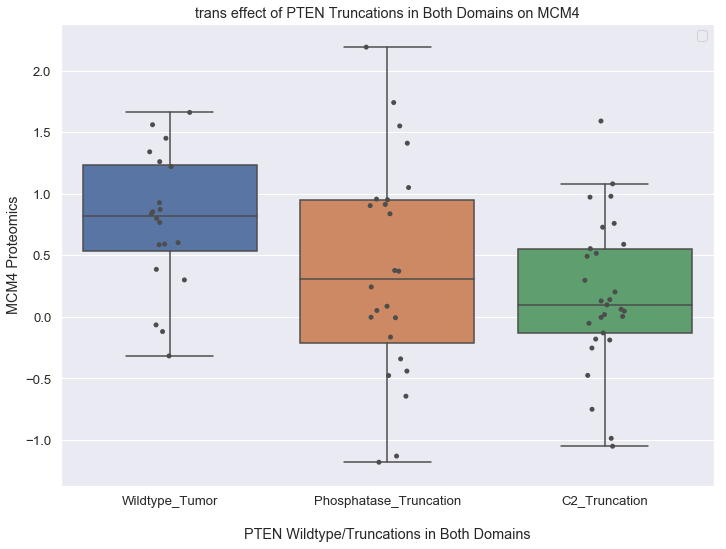

In [16]:
plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)



boxplot = sns.boxplot(x='Domain', y=t_gene+"_proteomics", data = all_df, 
                      order = ['Wildtype_Tumor','Phosphatase_Truncation','C2_Truncation'], 
                      showfliers = False)    
boxplot.set_title('trans effect of PTEN Truncations in Both Domains on '+t_gene)
boxplot = sns.stripplot(x='Domain', y=t_gene+"_proteomics", data = all_df, 
                        order = ['Wildtype_Tumor','Phosphatase_Truncation','C2_Truncation'],
                        jitter = True, color = ".3", dodge = True)
boxplot.set(xlabel = "\nPTEN Wildtype/Truncations in Both Domains", ylabel = t_gene+' Proteomics')

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 
#format_pval_annotation('***', 0, 1, 1.6)


plt.show()
plt.clf()
plt.close()